# Reinforcement Learning with Deep-Q Networks on Atari Space Invaders Environment

## Deep Q-Networks

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/Screenshot-2019-04-16-at-5.46.01-PM-850x558.png" width="800" height="800">

## Space Invaders

<img src="space_invader.gif">

In [1]:
!pip install gym keras-rl2

In [2]:
#from google.colab import files
#uploaded = files.upload()
!python -m atari_py.import_roms .

copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

In [3]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils
apt-get install imagemagick

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*



Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.11).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900)) # use False with Xvfb 
_ = _display.start()

In [5]:
import gym
from gym import wrappers
import numpy as np
import random
import math
import base64
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML
from IPython import display
from matplotlib import animation
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

import os
import io

In [6]:
env = gym.make("SpaceInvaders-v0")
height, width, channels = env.observation_space.shape
actions = env.action_space.n
print(env.unwrapped.get_action_meanings())
env.render()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


True

In [7]:
env.reset()
total_epochs = []
total_penalties = []
total_reward = []
frames = []

for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    epochs, penalties, reward = 0,0,0

    while not done:
        #env.render()
        action = env.action_space.sample()

        new_state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

        total_reward.append(reward)

        frames.append({'episode': episode, 'frames': env.render(mode='rgb_array'), 'state': state, 'action': action, 'reward': reward})

        state = new_state
    total_penalties.append(penalties)
    total_epochs.append(epochs)

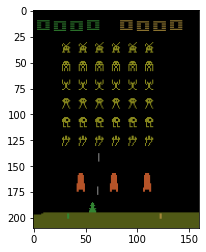

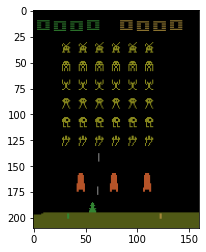

In [8]:
from IPython.display import clear_output
from time import sleep
img = plt.imshow(env.render(mode='rgb_array'))

def print_frames(frames):
    for i, frame in enumerate(frames):
        img.set_data(frame['frames']) # just update the data

        display.display(plt.gcf())
        
        if i == 100:
            break

        print(f"Episode: {frame['episode']}")
        #print(frame['frames'])
        print(f"Timestep: {i + 1}")
        #print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.5)
        
        clear_output(wait=True)
        
        
        
print_frames(frames)

In [9]:

def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

model = build_model(height, width, channels, actions)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 67584)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               34603520  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

In [10]:
memory = SequentialMemory(limit=1000, window_length=3)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                            nb_steps=1000)

dqn = DQNAgent(model=model, nb_actions=actions, policy=policy, memory=memory,
              enable_dueling_network=True, dueling_type='avg',
              nb_steps_warmup=1000, gamma=.99, target_model_update=50,
              train_interval=4, delta_clip=1.)



In [11]:
dqn.compile(Adam(lr=.00025), metrics=['mae'])

dqn.fit(env,
      nb_steps=2000,
      log_interval=1000,
      visualize=True,
      verbose=2)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training for 2000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  631/2000: episode: 1, duration: 24.432s, episode steps: 631, steps per second:  26, episode reward: 180.000, mean reward:  0.285 [ 0.000, 30.000], mean action: 2.597 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 1352/2000: episode: 2, duration: 192.167s, episode steps: 721, steps per second:   4, episode reward: 150.000, mean reward:  0.208 [ 0.000, 30.000], mean action: 2.248 [0.000, 5.000],  loss: 5.238421, mae: 12.845673, mean_q: 18.742170, mean_eps: 0.100000
done, took 542.665 seconds


In [12]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format("SpaceInvaders-v0"), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Episode 1: reward: 115.000, steps: 392
Episode 2: reward: 340.000, steps: 943
Episode 3: reward: 195.000, steps: 717
Episode 4: reward: 170.000, steps: 542
Episode 5: reward: 160.000, steps: 1103
